In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [7]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
spark = SparkSession.builder \
    .appName("example") \
    .master(f"spark://172.18.0.2:7077") \
    .config("spark.executor.cores", "1") \
    .config("spark.task.cpus", 1) \
    .config("spark.pyspark.virtualenv.enabled", "true") \
    .config("spark.pyspark.virtualenv.type", "native") \
    .config("spark.pyspark.virtualenv.requirements", "/work/reqs/reqs.txt") \
    .getOrCreate()

In [2]:
%%time

big_df = (
    spark
    .range(0, 1_000_000)
    .withColumn('val',f.rand())
)

big_df.cache()
big_df.show(3)

@f.pandas_udf('double', f.PandasUDFType.SCALAR)
def pandas_pdf(v):
    return pd.Series(stats.norm.pdf(v))

(
    big_df
    .withColumn('probability', pandas_pdf(big_df.val))
    .show(5)
)

+---+------------------+
| id|               val|
+---+------------------+
|  0|0.6242664344823765|
|  1|0.8289984396250024|
|  2|0.8139291709017323|
+---+------------------+
only showing top 3 rows



/opt/conda/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+---+------------------+-------------------+
| id|               val|        probability|
+---+------------------+-------------------+
|  0|0.6242664344823765|0.32831136944229555|
|  1|0.8289984396250024| 0.2829294403942166|
|  2|0.8139291709017323| 0.2864535512287373|
|  3|0.0896133138099815| 0.3973436298889499|
|  4|0.7524495099003106|0.30058380891284725|
+---+------------------+-------------------+
only showing top 5 rows

CPU times: user 203 ms, sys: 11.1 ms, total: 214 ms
Wall time: 11.7 s


In [4]:
pd.Series(stats.norm.pdf(0.5))

0    0.352065
dtype: float64

In [8]:
stats.norm.pdf(0)

0.3989422804014327

In [9]:
stats.norm.ppf(0.5)

0.0

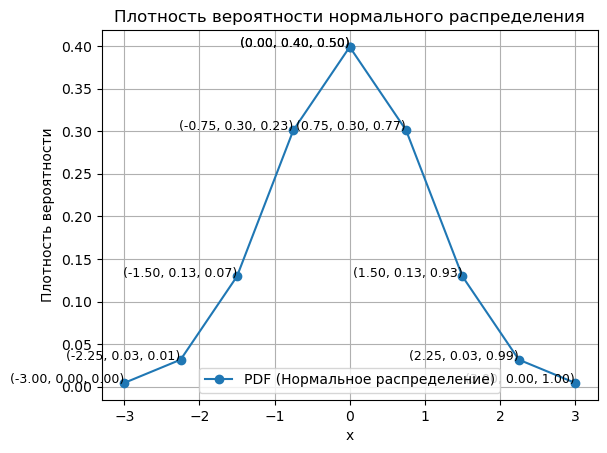

      x    pdf(x)    cdf(x)
0 -3.00  0.004432  0.001350
1 -2.25  0.031740  0.012224
2 -1.50  0.129518  0.066807
3 -0.75  0.301137  0.226627
4  0.00  0.398942  0.500000
5  0.00  0.398942  0.500000
6  0.75  0.301137  0.773373
7  1.50  0.129518  0.933193
8  2.25  0.031740  0.987776
9  3.00  0.004432  0.998650


In [10]:
# Генерация 9 точек на оси x, включая 0
x = np.linspace(-3, 3, 9)  # Создаем 9 точек в диапазоне
x = np.append(x, 0)        # Добавляем 0 к этим точкам
x = np.sort(x)             # Сортируем точки, чтобы они были упорядочены

# Вычисление значений плотности вероятности для этих точек
y = stats.norm.pdf(x)

# Вычисление значений CDF для этих точек
cdf_values = stats.norm.cdf(x)

# Построение графика
plt.plot(x, y, 'o-', label='PDF (Нормальное распределение)')
plt.title('Плотность вероятности нормального распределения')
plt.xlabel('x')
plt.ylabel('Плотность вероятности')
plt.grid(True)

# Добавление подписей для каждой точки
for (xi, yi, ci) in zip(x, y, cdf_values):
    plt.text(xi, yi, f'({xi:.2f}, {yi:.2f}, {ci:.2f})', fontsize=9, ha='right')

plt.legend()
plt.show()

# Создание списка кортежей и вывод его на печать
results = [(xi, yi, ci) for (xi, yi, ci) in zip(x, y, cdf_values)]
# print(results)

# Создание DataFrame для удобного копирования данных
df = pd.DataFrame(results, columns=['x', 'pdf(x)', 'cdf(x)'])
print(df)

PDF: Значение 0.398942 для pdf(0) означает, что плотность вероятности в точке x=0 равна примерно 0.398942. Это значение показывает высоту кривой плотности вероятности в этой точке. Это не вероятность как таковая, так как вероятность для непрерывного распределения в точке равна нулю. Плотность вероятности может быть интерпретирована как вероятность на единицу интервала вокруг этой точки.

CDF: Значение 0.5 для cdf(0) означает, что вероятность того, что случайная переменная примет значение, меньшее или равное 0, равна 0.5. Это значение показывает накопленную вероятность от −∞ до 0


Когда мы говорим о значении плотности вероятности в точке x=0, которое составляет примерно 0.398942, это может быть интуитивно воспринято как "вероятность", но на самом деле это значение представляет собой плотность вероятности в этой точке. Это означает, что чем ближе значение к этой точке, тем выше вероятность получить случайное значение в этой области. Однако для непрерывных распределений вероятность попасть в конкретную точку стремится к нулю.

В этом контексте можно интерпретировать 0.398942 как вероятность в каком-то смысле, но не как точную вероятность попасть в точку x=0, а скорее как интегральную вероятность попасть в бесконечно малый интервал вокруг x=0. Таким образом, значение 0.398942 можно рассматривать как вероятность в пределе вокруг точки x=0.



формула нормального распределения $f(x|\mu,\sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$ очень красива


## Наглядный пример про плотность

Представим себе коробку, наполненную шариками разных цветов. Для нашего изучения выберем конкретный цвет, например, красный. Плотность вероятности в этом случае можно представить как количество красных шариков, сосредоточенных в определенном объеме внутри коробки.

Допустим, мы разбиваем коробку на маленькие кубики объемом 1куб.см. Если коробка заполнена очень плотно, то в каждом кубике будет много красных шариков. Это означает, что плотность вероятности, то есть вероятность найти красный шарик в любом данном объеме (в данном случае, кубике), очень высока.

Однако, в определенных областях коробки может быть больше шариков, чем в других. Например, если красные шарики сконцентрированы в одной части коробки, то плотность вероятности в этой области будет выше, чем в других местах.

Допустим теперь мы двигаемся внутри коробки, проходя через различные слои, и накапливаем шарики. В более плотных областях этот процесс происходит быстрее, так как в каждом слое будет больше шариков. Это проиллюстрировано с помощью функции накопленного распределения (CDF). Накопленная вероятность показывает, сколько шариков мы встречаем по мере движения внутри коробки.

Таким образом, плотность вероятности в данном случае можно представить как "плотность" шариков (в данном случае красных) внутри коробки. Чем больше шариков на единицу объема, тем выше плотность вероятности нахождения красного шарика в этом объеме.